# ID/X Partners x Rakamin Final Project


Proyek ini bertujuan untuk mengembangkan solusi teknologi bagi perusahaan pemberi pinjaman guna memprediksi risiko kredit dengan lebih akurat. Dataset yang digunakan berisi data pinjaman yang diterima dan ditolak sebagai dasar untuk membangun model prediksi. Selain itu, akan diciptakan media visual yang komunikatif untuk mempresentasikan hasil kepada klien. Proyek ini akan mengikuti metodologi Data Science end-to-end, memungkinkan pengembangan solusi yang dapat mengurangi risiko kredit dan meningkatkan keputusan persetujuan pinjaman.

**Pramudya Kusuma H**

## Import Library

In [ ]:
import itertools
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import chi2_contingency

## Load Data

Mengimport data dan melihat contoh isi data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
loan_df = pd.read_csv('/content/drive/MyDrive/IDX/loan_data_2007_2014.csv')

<ipython-input-77-146ab998c75b>:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_df = pd.read_csv('/content/drive/MyDrive/IDX/loan_data_2007_2014.csv')


In [ ]:
loan_df.head(5)

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501,Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077430,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br> Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077175,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1076863,"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time.<br>",other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1075358,"Borrower added on 12/21/11 > I plan on combining three large interest bills together and f

## Deskripsi Data

Melihat informasi yang ada pada data, dan deskripsi masing-masing kolom pada data

In [ ]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

## EDA & Feature Selection

In [ ]:
title_font = dict(size=20, weight="bold")

def plot_count(df, y, title, **sns_kwargs):
    value_counts = df[y].value_counts()
    percentage = value_counts / value_counts.sum()
    percentage = percentage.apply("{:.2%}".format)

    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.countplot(data=df, y=y, order=value_counts.index, **sns_kwargs)
    plt.ylabel("")
    plt.show()

    print(percentage)


def plot_distribution(df, x, title, **sns_kwargs):
    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.histplot(data=df, x=x, kde=True, **sns_kwargs)
    plt.ylabel("")
    plt.show()


def plot_boxplot(df, x, y, title, **sns_kwargs):
    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.boxplot(data=df, x=x, y=y, **sns_kwargs)
    plt.ylabel("")
    plt.show()

### Status Pinjaman (`Y`)
Tujuan analisis kali ini adalah memprediksi kelayakan seseorang menerima pinjaman. Hal tersebut dapat dilihat dari berhasil atau tidaknya seseorang membayar tagihan pinjaman.

#### Menentukan Kategori Status Pinjaman
Untuk menyederhanakan kategori dari variabel Y nantinya, `loan_status` dikelompokkan menjadi berhasil bayar yang akan menjadi 'Good Loans', dan gagal bayar yang akan menjadi 'Bad Loans' pada variabel `Y` nantinya. Oleh karena itu kita hanya akan mengambil 2 kategori yaitu:
- Good Loans, terdiri dari: Fully Paid
- Bad Loans, terdiri dari: Charged Off, Default, dan Does not meet the credit policy

Tidak menggunakan `current` karena pinjaman tersebut masih berlangsung, begitu pula dengan `late` dan `in_grace_period`.

In [ ]:
good_loans = ["Fully Paid"]
bad_loans = [
    "Charged Off",
    "Default",
    "Does not meet the credit policy. Status:Fully Paid",
    "Does not meet the credit policy. Status:Charged Off"
]

In [ ]:
def label_loan(value):
    if value in good_loans:
        return 1
    return 0

label_loan("Fully Paid")

1

In [ ]:
# Jalankan fungsi
y_fix_df = loan_df[loan_df["loan_status"].isin(good_loans + bad_loans)].copy()
y_fix_df["loan_status"] = y_fix_df["loan_status"].apply(label_loan)

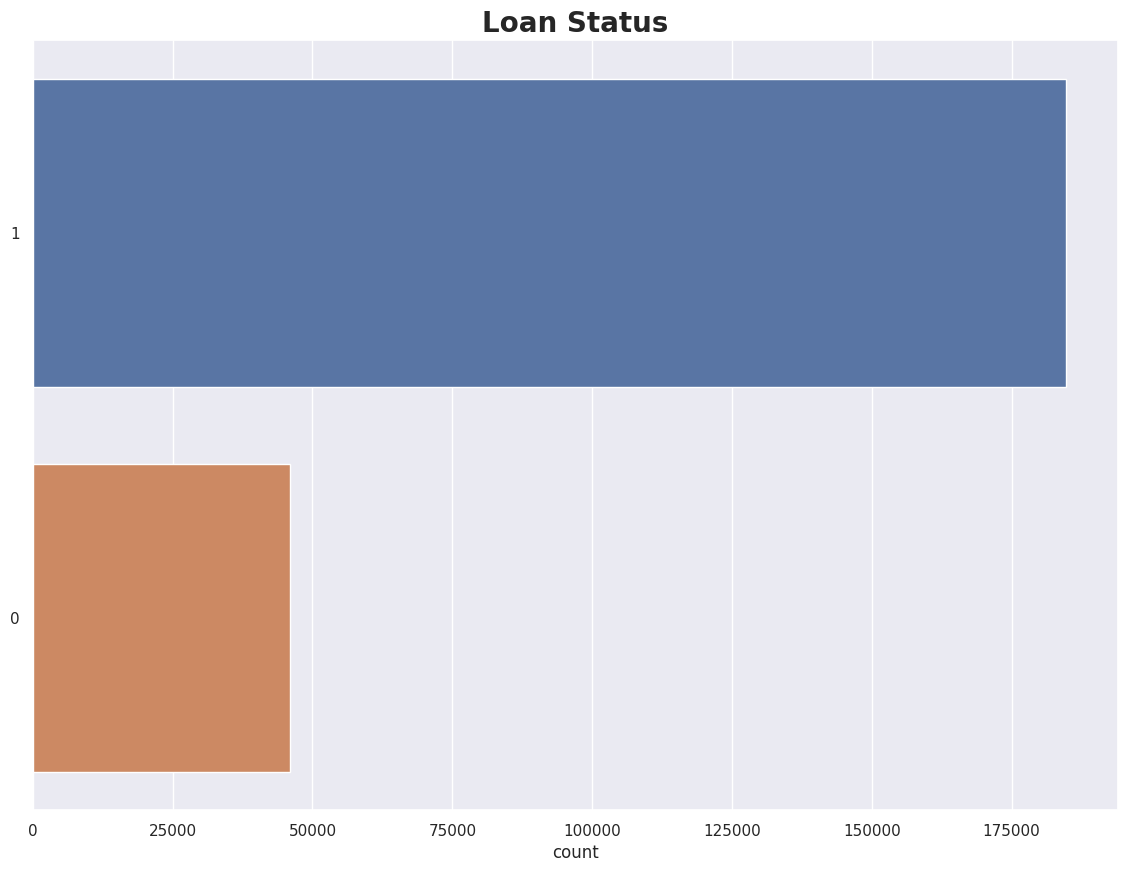

1    80.04%
0    19.96%
Name: loan_status, dtype: object


In [ ]:
plot_count(y_fix_df, y="loan_status", title="Loan Status")

### Menganalisis Variabel `X`

Menganalisis variabel `X` berdasarkan korelasi dengan variabel `Y` (`loan_status`), Khusus variabel bertipe date tidak akan digunakan karena kali ini tidak tergantung waktu.

In [ ]:
# Menghapus Variabel bertipe date
date_cols = ["issue_d", "earliest_cr_line", "last_pymnt_d", "last_credit_pull_d", "next_pymnt_d"]
y_fix_df = y_fix_df.drop(columns=date_cols,errors="ignore")
y_fix_df.head(5)

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,1,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501,Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>,credit_card,Computer,860xx,AZ,27.65,0.0,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,0,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077430,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br> Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>,car,bike,309xx,GA,1.00,0.0,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,1,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077175,NaN,small_business,real estate business,606xx,IL,8.72,0.0,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,1,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1076863,"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time.<br>",other,personel,917xx,CA,20.00,0.0,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,1075269,1311441,5000,5000,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,RENT,36000.0,Source Verified,1,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1075269,NaN,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,0.0,3.0,NaN,NaN,9.0,0.0,7963,28.3,12.0,f,0.0,0.0,5631.377753,5631.38,5000.00,631.38,0.00,0.00,0.00,161.03,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###Menghitung korelasi X dan Y

In [ ]:
correlations = (y_fix_df.select_dtypes(exclude=object)
                         .corr()
                         .dropna(how="all", axis=0)
                         .dropna(how="all", axis=1)
)

In [ ]:
correlations["loan_status"].abs().sort_values(ascending=False)

loan_status                    1.000000
total_rec_prncp                0.460338
recoveries                     0.445422
last_pymnt_amnt                0.384781
total_pymnt_inv                0.358588
total_pymnt                    0.355349
collection_recovery_fee        0.300094
int_rate                       0.241059
total_rec_late_fee             0.152231
inq_last_6mths                 0.116393
dti                            0.107257
out_prncp                      0.099816
out_prncp_inv                  0.099814
revol_util                     0.089180
tot_cur_bal                    0.076230
mths_since_last_record         0.062190
annual_inc                     0.061623
total_rev_hi_lim               0.052931
loan_amnt                      0.049253
funded_amnt                    0.048790
funded_amnt_inv                0.039854
installment                    0.033419
total_rec_int                  0.032997
total_acc                      0.030680
mths_since_last_delinq         0.029299


In [ ]:
# Saring korelasi antara vmin - vmax
vmin, vmax = 0.1, 0.99

unstack_corr = correlations.unstack()
pos_corr = (unstack_corr > vmin) & (unstack_corr < vmax)
neg_corr = (unstack_corr > -vmax) & (unstack_corr < -vmin)
high_corr = unstack_corr[pos_corr | neg_corr]

trimmed_corr = high_corr.sort_values(ascending=False).unstack()

In [ ]:
correlated_loan = high_corr.loc["loan_status"].sort_values(ascending=False)
correlated_loan

total_rec_prncp            0.460338
last_pymnt_amnt            0.384781
total_pymnt_inv            0.358588
total_pymnt                0.355349
dti                       -0.107257
inq_last_6mths            -0.116393
total_rec_late_fee        -0.152231
int_rate                  -0.241059
collection_recovery_fee   -0.300094
recoveries                -0.445422
dtype: float64

Didapatkan sebanyak 10 variabel `X` yang cukup berkorelasi dengan `loan_status`

In [ ]:
# Membatasi korelasi
threshold = 0.5
corr_trimmed = (high_corr.abs()
                             .loc[high_corr > threshold]
                             .loc[correlated_loan.index, correlated_loan.index]
                             .sort_values(ascending=False)
)
corr_trimmed

<ipython-input-91-182d73521e19>:3: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  corr_trimmed = (high_corr.abs()


total_rec_prncp          total_pymnt                0.975030
total_pymnt              total_rec_prncp            0.975030
total_rec_prncp          total_pymnt_inv            0.969473
total_pymnt_inv          total_rec_prncp            0.969473
collection_recovery_fee  recoveries                 0.798358
recoveries               collection_recovery_fee    0.798358
total_rec_prncp          last_pymnt_amnt            0.744957
last_pymnt_amnt          total_rec_prncp            0.744957
                         total_pymnt_inv            0.691699
total_pymnt_inv          last_pymnt_amnt            0.691699
last_pymnt_amnt          total_pymnt                0.688667
total_pymnt              last_pymnt_amnt            0.688667
dtype: float64

In [ ]:
corr_variables = list(set(corr_trimmed.index.get_level_values(0)))
corr_variables

['collection_recovery_fee',
 'total_pymnt',
 'total_rec_prncp',
 'recoveries',
 'last_pymnt_amnt',
 'total_pymnt_inv']

In [ ]:
# Memilih berdasarkan korelasi yang paling besar
correlated_loan[corr_variables].sort_values(ascending=False)

total_rec_prncp            0.460338
last_pymnt_amnt            0.384781
total_pymnt_inv            0.358588
total_pymnt                0.355349
collection_recovery_fee   -0.300094
recoveries                -0.445422
dtype: float64

In [ ]:
correlated_num_features = ['last_pymnt_amnt','total_pymnt_inv','total_pymnt','collection_recovery_fee']
num_features = [feature for feature in correlated_loan.index if feature not in correlated_num_features]
num_features

['total_rec_prncp',
 'dti',
 'inq_last_6mths',
 'total_rec_late_fee',
 'int_rate',
 'recoveries']

### Mengecek Variabel `X` Kategorik

In [ ]:
# Kolom-kolom yang berdata kategorik
cat_features = y_fix_df.select_dtypes(include=object).columns
cat_features

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'pymnt_plan', 'url', 'desc',
       'purpose', 'title', 'zip_code', 'addr_state', 'initial_list_status',
       'application_type'],
      dtype='object')

Beberapa kolom kategorikal yang tidak terpakai adalah:
- desc dan title karena merupakan teks.
- zip_code
- sub_grade

In [ ]:
del_cols = ["desc", "zip_code", "sub_grade", "title"]
cat_features = [col for col in cat_features if col not in del_cols]

In [ ]:
# unique value
y_fix_df[cat_features].nunique()

term                        2
grade                       7
emp_title              126879
emp_length                 11
home_ownership              6
verification_status         3
pymnt_plan                  2
url                    230795
purpose                    14
addr_state                 50
initial_list_status         2
application_type            1
dtype: int64

In [ ]:
cat_features = [col for col in cat_features if col not in ['emp_title','url','application_type']]
cat_features

['term',
 'grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'initial_list_status']

In [ ]:
# Melihat preview data variabel prediktor kategorik
y_fix_df[cat_features]

,term,grade,emp_length,home_ownership,verification_status,pymnt_plan,purpose,addr_state,initial_list_status
0,36 months,B,10+ years,RENT,Verified,n,credit_card,AZ,f
1,60 months,C,< 1 year,RENT,Source Verified,n,car,GA,f
2,36 months,C,10+ years,RENT,Not Verified,n,small_business,IL,f
3,36 months,C,10+ years,RENT,Source Verified,n,other,CA,f
5,36 months,A,3 years,RENT,Source Verified,n,wedding,AZ,f
...,...,...,...,...,...,...,...,...,...
466276,60 months,D,5 years,MORTGAGE,Verified,n,medical,MA,f
466277,36 months,A,3 years,RENT,Verified,n,debt_consolidation,MD,f
466278,36 months,D,10+ years,RENT,Source Verified,n,vacation,VA,f
466281,60 months,D,10+ years,MORTGAGE,Verified,n,debt_consolidation,TN,f


In [ ]:
cat_features = [feature for feature in cat_features if feature not in ["pymnt_plan","initial_list_status"]]
cat_features

['term',
 'grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state']

Karena keseluruhan variabel `X` kategorik saling berkaitan, maka dipilih 2 variabel yang memiliki pengaruh paling besar pada `loan_satus` yani `term` dan `grade`

In [ ]:
cat_features = ['term','grade']

### Visualisasi

In [ ]:
y_fix_df[num_features]

,total_rec_prncp,dti,inq_last_6mths,total_rec_late_fee,int_rate,recoveries
0,5000.00,27.65,1.0,0.00,10.65,0.00
1,456.46,1.00,5.0,0.00,15.27,117.08
2,2400.00,8.72,2.0,0.00,15.96,0.00
3,10000.00,20.00,1.0,16.97,13.49,0.00
5,5000.00,11.20,3.0,0.00,7.90,0.00
...,...,...,...,...,...,...
466276,360.08,12.28,0.0,0.00,18.25,1159.40
466277,4580.89,10.33,0.0,0.00,7.90,0.00
466278,10000.00,11.57,0.0,0.00,18.25,0.00
466281,1837.04,18.45,5.0,0.00,19.97,0.00


### Status Pinjaman 6 Bulan terakhir

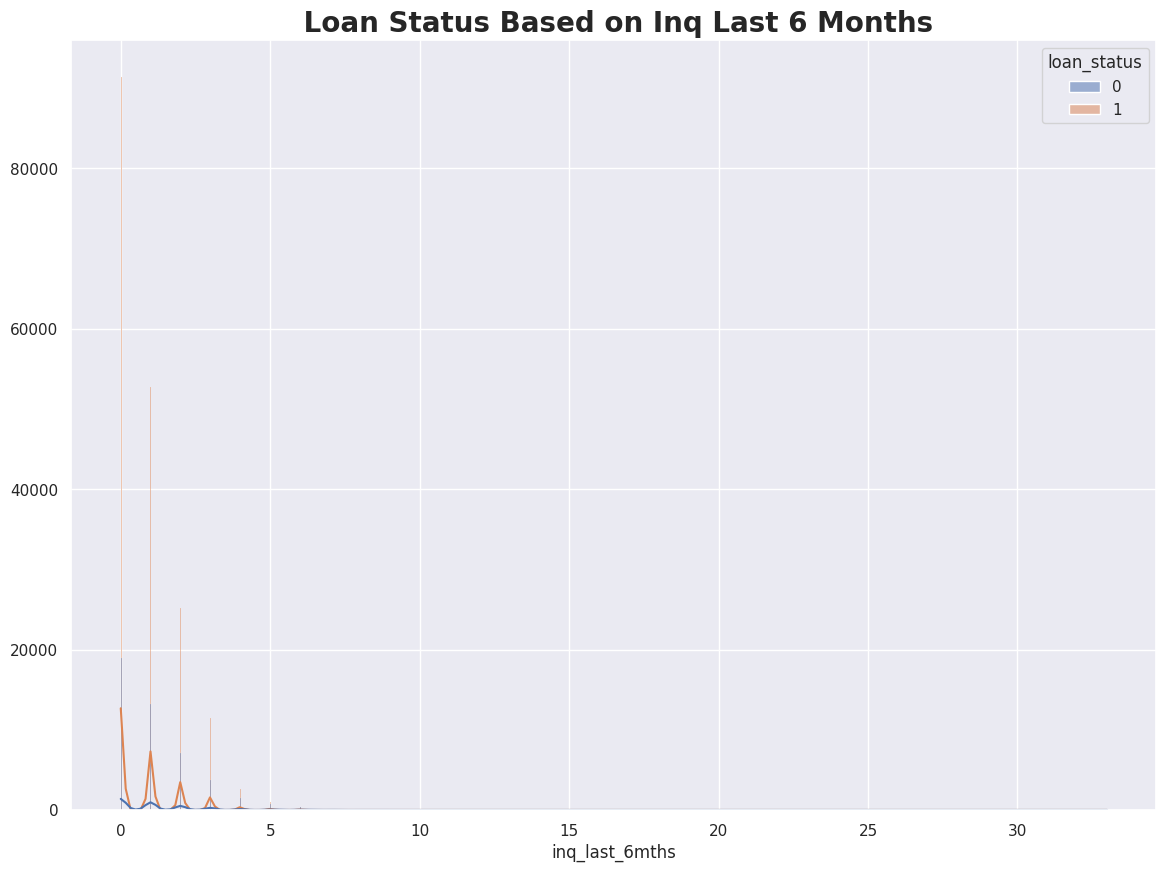

In [ ]:
plot_distribution(df=y_fix_df, x="inq_last_6mths", hue="loan_status", title=" Loan Status Based on Inq Last 6 Months")

Semakin sedikit jumlah penyelidikan dalam 6 bulan terakhir, semakin besar peluang orang tersebut berhasil bayar

### Status Pinjaman
Berdasarkan besar biaya keterlambatan yang sudah dibayarkan


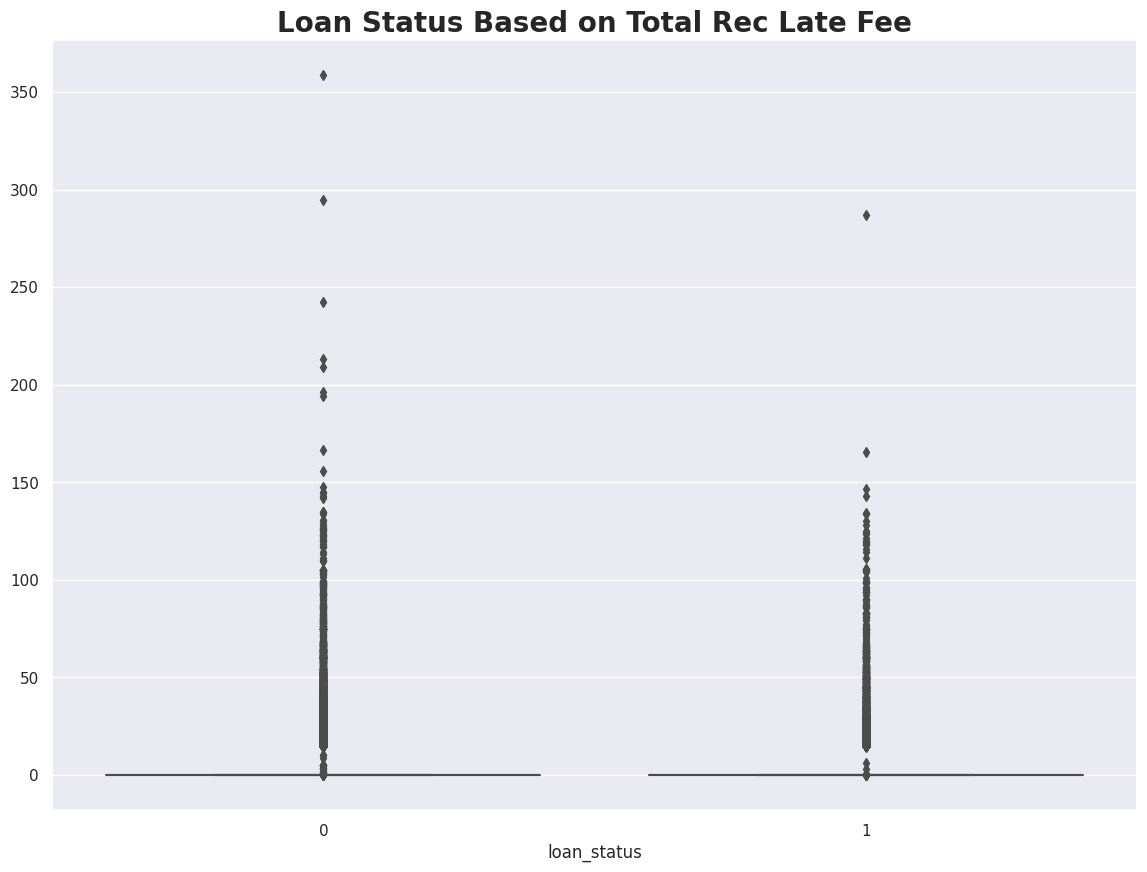

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,46056.0,2.573979,10.409126,0.0,0.0,0.0,0.0,358.680000
1,184739.0,0.365995,3.741159,0.0,0.0,0.0,0.0,286.747566


In [ ]:
x, y = "loan_status", "total_rec_late_fee"
plot_boxplot(df=y_fix_df, x=x, y=y, title="Loan Status Based on Total Rec Late Fee")
y_fix_df.groupby(x)[y].describe()

Orang yang berhasil bayar memiliki biaya keterlambatan yang dibayarkan yang cenderung lebih kecil

In [ ]:
y_fix_df[cat_features]

,term,grade
0,36 months,B
1,60 months,C
2,36 months,C
3,36 months,C
5,36 months,A
...,...,...
466276,60 months,D
466277,36 months,A
466278,36 months,D
466281,60 months,D


### Status Pinjaman Berdasarkan Grade
Semakin tinggi Grade (Semakin mendekati grade G) maka bunga pinjaman (int_rate) akan semakin besar

In [ ]:
data_freq = y_fix_df.groupby(['grade','loan_status']).count()['id']
data_freq = data_freq.reset_index()
data_freq

,grade,loan_status,id
0,A,0,2655
1,A,1,36455
2,B,0,9660
3,B,1,60962
4,C,0,12808
5,C,1,45818
6,D,0,10651
7,D,1,26089
8,E,0,6376
9,E,1,10569


#### Status Pinjaman dan Term
Waktu pembayaran yang akan ditempuh (36/60 bulan)

In [ ]:
data_freq_term = y_fix_df.groupby(['term','loan_status']).count()['id']
data_freq_term = data_freq_term.reset_index()
data_freq_term

,term,loan_status,id
0,36 months,0,30383
1,36 months,1,151101
2,60 months,0,15673
3,60 months,1,33638


## Data Preparation

In [ ]:
# Menggunakan fitur yang telah dipilih
prep_df = y_fix_df[num_features+cat_features+['loan_status']]
prep_df

,total_rec_prncp,dti,inq_last_6mths,total_rec_late_fee,int_rate,recoveries,term,grade,loan_status
0,5000.00,27.65,1.0,0.00,10.65,0.00,36 months,B,1
1,456.46,1.00,5.0,0.00,15.27,117.08,60 months,C,0
2,2400.00,8.72,2.0,0.00,15.96,0.00,36 months,C,1
3,10000.00,20.00,1.0,16.97,13.49,0.00,36 months,C,1
5,5000.00,11.20,3.0,0.00,7.90,0.00,36 months,A,1
...,...,...,...,...,...,...,...,...,...
466276,360.08,12.28,0.0,0.00,18.25,1159.40,60 months,D,0
466277,4580.89,10.33,0.0,0.00,7.90,0.00,36 months,A,0
466278,10000.00,11.57,0.0,0.00,18.25,0.00,36 months,D,1
466281,1837.04,18.45,5.0,0.00,19.97,0.00,60 months,D,0


In [ ]:
# Checking null value
prep_df.isna().sum()

total_rec_prncp        0
dti                    0
inq_last_6mths        29
total_rec_late_fee     0
int_rate               0
recoveries             0
term                   0
grade                  0
loan_status            0
dtype: int64

In [ ]:
# drop null value
prep_df = prep_df.dropna()

In [ ]:
# Checking null value
prep_df.isna().sum()

total_rec_prncp       0
dti                   0
inq_last_6mths        0
total_rec_late_fee    0
int_rate              0
recoveries            0
term                  0
grade                 0
loan_status           0
dtype: int64

### Data Preprocessing

In [ ]:
num_features_data = prep_df.select_dtypes(exclude="object")
cat_features_data = prep_df.select_dtypes(include="object")

In [ ]:
# OneHotEncode fitur kategorik
cat_features_data = pd.get_dummies(cat_features_data)
cat_features_data

,term_ 36 months,term_ 60 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,1,0,0,1,0,0,0,0,0
1,0,1,0,0,1,0,0,0,0
2,1,0,0,0,1,0,0,0,0
3,1,0,0,0,1,0,0,0,0
5,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
466276,0,1,0,0,0,1,0,0,0
466277,1,0,1,0,0,0,0,0,0
466278,1,0,0,0,0,1,0,0,0
466281,0,1,0,0,0,1,0,0,0


In [ ]:
main_df = pd.concat([num_features_data,cat_features_data],axis=1)
main_df

,total_rec_prncp,dti,inq_last_6mths,total_rec_late_fee,int_rate,recoveries,loan_status,term_ 36 months,term_ 60 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,5000.00,27.65,1.0,0.00,10.65,0.00,1,1,0,0,1,0,0,0,0,0
1,456.46,1.00,5.0,0.00,15.27,117.08,0,0,1,0,0,1,0,0,0,0
2,2400.00,8.72,2.0,0.00,15.96,0.00,1,1,0,0,0,1,0,0,0,0
3,10000.00,20.00,1.0,16.97,13.49,0.00,1,1,0,0,0,1,0,0,0,0
5,5000.00,11.20,3.0,0.00,7.90,0.00,1,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466276,360.08,12.28,0.0,0.00,18.25,1159.40,0,0,1,0,0,0,1,0,0,0
466277,4580.89,10.33,0.0,0.00,7.90,0.00,0,1,0,1,0,0,0,0,0,0
466278,10000.00,11.57,0.0,0.00,18.25,0.00,1,1,0,0,0,0,1,0,0,0
466281,1837.04,18.45,5.0,0.00,19.97,0.00,0,0,1,0,0,0,1,0,0,0


In [ ]:
main_df.isna().sum()

total_rec_prncp       0
dti                   0
inq_last_6mths        0
total_rec_late_fee    0
int_rate              0
recoveries            0
loan_status           0
term_ 36 months       0
term_ 60 months       0
grade_A               0
grade_B               0
grade_C               0
grade_D               0
grade_E               0
grade_F               0
grade_G               0
dtype: int64

In [ ]:
# Mendefinisikan variabel Y
Y = main_df['loan_status'].values.copy()
Y

array([1, 0, 1, ..., 1, 0, 1])

In [ ]:
all_features_data = main_df[[i for i in main_df.columns if i!='loan_status']]
all_features_data

,total_rec_prncp,dti,inq_last_6mths,total_rec_late_fee,int_rate,recoveries,term_ 36 months,term_ 60 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,5000.00,27.65,1.0,0.00,10.65,0.00,1,0,0,1,0,0,0,0,0
1,456.46,1.00,5.0,0.00,15.27,117.08,0,1,0,0,1,0,0,0,0
2,2400.00,8.72,2.0,0.00,15.96,0.00,1,0,0,0,1,0,0,0,0
3,10000.00,20.00,1.0,16.97,13.49,0.00,1,0,0,0,1,0,0,0,0
5,5000.00,11.20,3.0,0.00,7.90,0.00,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466276,360.08,12.28,0.0,0.00,18.25,1159.40,0,1,0,0,0,1,0,0,0
466277,4580.89,10.33,0.0,0.00,7.90,0.00,1,0,1,0,0,0,0,0,0
466278,10000.00,11.57,0.0,0.00,18.25,0.00,1,0,0,0,0,1,0,0,0
466281,1837.04,18.45,5.0,0.00,19.97,0.00,0,1,0,0,0,1,0,0,0


## Build Model

### Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_features_data, Y, test_size=0.2, random_state=42, stratify=Y)

In [ ]:
X_train.shape, y_train.shape

((184612, 15), (184612,))

### Model

In [ ]:
logreg = LogisticRegression(max_iter=500, solver="sag", class_weight="balanced", n_jobs=-1)
logreg

LogisticRegression(class_weight='balanced', max_iter=500, n_jobs=-1,
                   solver='sag')

In [ ]:
logreg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=500, n_jobs=-1,
                   solver='sag')

## Save Model

In [ ]:
joblib.dump(logreg, "logreg.z")

['logreg.z']

In [ ]:
logreg = joblib.load("logreg.z")

## Evaluasi Model

Kita akan membuat model prediksi paling sederhana yaitu dengan memprediksi seluruh data kategori terbanyak.

In [ ]:
y_test

array([0, 1, 1, ..., 1, 0, 1])

In [ ]:
test_label_counts = dict(Counter(y_test))
test_label_counts

{0: 9206, 1: 36948}

In [ ]:
max(test_label_counts.values()) / sum(test_label_counts.values())

0.8005373315422282

## Metrik Klasifikasi

### Train

In [ ]:
logreg.score(X_train, y_train)

0.8850995601586029

## Test

In [ ]:
logreg.score(X_test, y_test)

0.8858387138709538